In [2]:
using MLDatasets, Flux, LinearAlgebra, ProgressMeter, Zygote, ReverseDiff, CairoMakie
include("DenseNTK.jl"); include("FastNTKMethods.jl")

function load_MNIST()
    """
    Loading the MNIST dataset.
    10 classes of digits from 0 to 9,
    each with 28x28 pixel dimensions.
    X: Grayscale vector, Y: Correct label.
    """

    X_training, Y_training = MNIST(split = :train)[:]
    X_testing, Y_testing = MNIST(split = :test)[:]
    X_training = Flux.flatten(X_training)
    X_testing = Flux.flatten(X_testing)
    Y_training = Flux.onehotbatch(Y_training, 0:9)
    Y_testing = Flux.onehotbatch(Y_testing, 0:9)
    return X_training, Y_training, X_testing, Y_testing
end

### MODELS
DenseNTKmodel = Chain(
  DenseNTK(28 * 28, 16, sigmoid),        # 784 x 16 + 16 = 12560 parameters
  DenseNTK(16, 16, sigmoid),             #  16 x 16 + 16 =   272 parameters
  DenseNTK(16, 16, sigmoid),             #  16 x 16 + 16 =   272 parameters
  DenseNTK(16, 10, sigmoid)              #  16 x 10 + 10 =   170 parameters
)  

model = Chain(
  Dense(28 * 28, 16, sigmoid),        # 784 x 16 + 16 = 12560 parameters
  Dense(16, 16, sigmoid),             #  16 x 16 + 16 =   272 parameters
  Dense(16, 16, sigmoid),             #  16 x 16 + 16 =   272 parameters
  Dense(16, 10, sigmoid)              #  16 x 10 + 10 =   170 parameters
)   

### DATA 
N=20
x = load_MNIST()[1][:,1:N];

In [17]:
K1 = kernel(DenseNTKmodel, x, true, 1);
K2 = kernel(DenseNTKmodel, x, true, 2);
K3 = kernel(DenseNTKmodel, x, true, 3);


ReverseDiff Jacobian: 0.192101 seconds (1.16 k allocations: 51.012 MiB, 5.70% gc time)
Kernel computation: 0.005482 seconds (3 allocations: 312.562 KiB)

ReverseDiff Jacobian: 0.270641 seconds (1.75 M allocations: 133.141 MiB, 5.82% gc time)
Kernel computation: 0.006317 seconds (3 allocations: 312.562 KiB)

Zygote Jacobian: 0.082525 seconds (27.07 k allocations: 166.320 MiB, 15.25% gc time)
Kernel computation: 0.007215 seconds (3 allocations: 312.562 KiB)


In [18]:
E1 = eigen(K1).values
E2 = eigen(K2).values
E3 = eigen(K3).values

println("Eigen values:")
hcat(E1, E2, E3)

Eigen values:


200×3 Matrix{Float64}:
 1.09861e-10  9.60773e-11  9.60773e-11
 1.81364e-10  1.58384e-10  1.58385e-10
 2.00628e-10  2.38927e-10  2.38928e-10
 2.87715e-10  2.66728e-10  2.66728e-10
 3.17734e-10  3.24002e-10  3.24002e-10
 3.57248e-10  3.62458e-10  3.62457e-10
 4.48197e-10  3.85257e-10  3.85256e-10
 4.92876e-10  4.03423e-10  4.03423e-10
 5.7026e-10   4.79449e-10  4.79449e-10
 6.77687e-10  4.86938e-10  4.86937e-10
 ⋮                         
 0.0119336    0.0119383    0.0119383
 0.0666494    0.066697     0.066697
 0.138379     0.138403     0.138403
 0.154279     0.154349     0.154349
 0.233498     0.233569     0.233569
 0.278384     0.278341     0.278341
 0.342066     0.342122     0.342122
 0.349386     0.349453     0.349453
 0.403336     0.403414     0.403414

In [154]:
#display(K1); display(K2); display(K3)

<h1>5% of MNIST</h1>

In [168]:
### DATA 
N=3000
x5 = load_MNIST()[1][:,1:N];

In [169]:
K1 = kernel(DenseNTKmodel, x5, true, 1);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46



ReverseDiff Jacobian: 45.041085 seconds (188.48 k allocations: 7.473 GiB, 36.03% gc time)
Kernel computation: 69.035340 seconds (3 allocations: 6.706 GiB, 0.00% gc time)


<h1>Performance breakdown</h1>

In [3]:
# Fake data
Nx=500
a=-1.0; b=1.0

xVec=hcat(collect(range(a,stop=b,length=Nx))...);
yVec=sin.(2*pi*xVec) .+ 0.1*randn(size(xVec));

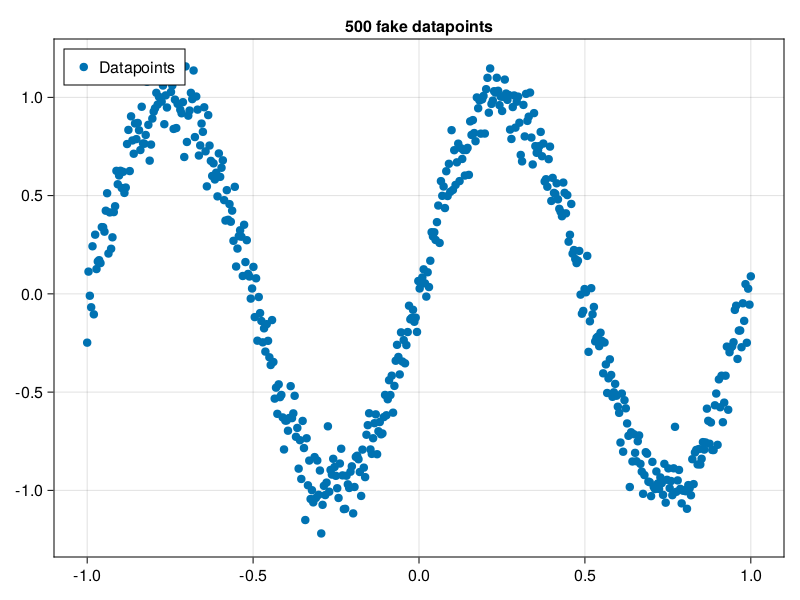

In [5]:
fig = Figure()
ax1 = Axis(fig[1,1], title="$Nx fake datapoints")
CairoMakie.scatter!(xVec[:], yVec[:], label="Datapoints")
axislegend(ax1,position=:lt)
fig

In [25]:
### MODELS
model = Chain(
  DenseNTK(1, 16, relu),   
  DenseNTK(16, 16, relu),  
  DenseNTK(16, 16, relu),  
  DenseNTK(16, 1)          
);

model(xVec)

1×500 Matrix{Float64}:
 -1.27566  -1.27609  -1.27652  -1.27695  …  -1.61249  -1.61341  -1.61433

In [34]:
runs = 1

K1 = []; K2 = []; K3 = [];

@showprogress for i = 1:runs
    model = Chain(
    DenseNTK(1, 16, relu),       
    DenseNTK(16, 16, relu),   
    DenseNTK(16, 16, relu),      
    DenseNTK(16, 1)              
    );

    push!(K1, kernel(model,xVec,false,1))
    push!(K2, kernel(model,xVec,false,2))
    push!(K3, kernel(model,xVec,false,3))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


100-element Vector{Any}:
 [1.2507396077011903 1.2509221745366956 … 1.3416578917829756 1.3418404586184811; 1.2509221745366956 1.251106612589664 … 1.3427723249149077 1.342956762967876; … ; 1.3416578917829756 1.3427723249149077 … 1.896645591485189 1.8977600246171213; 1.3418404586184811 1.342956762967876 … 1.8977600246171213 1.898876328966516]
 [1.1987624219661102 1.197609008093913 … 0.6243623136119754 0.6232088997397784; 1.197609008093913 1.196459185599306 … 0.6249974057796648 0.6238475832850578; … ; 0.6243623136119754 0.6249974057796648 … 0.9406382131212958 0.9412733052889852; 0.6232088997397784 0.6238475832850578 … 0.9412733052889852 0.9419119888342649]
 [1.2357143771951815 1.2359962036033274 … 1.3760639284517258 1.3763457548598717; 1.2359962036033274 1.236282739130502 … 1.3786908961363302 1.378977431663505; … ; 1.3760639284517258 1.3786908961363302 … 2.684293835384602 2.6869208030692064; 1.3763457548598717 1.378977431663505 … 2.6869208030692064 2.68955247987284]
 [1.1471867418581998 1.

100-element Vector{Any}:
 [1.2507396077011903 1.2509221745366956 … 0.8795615432539563 0.879496577564643; 1.2509221745366956 1.251106612589664 … 0.8796941503856304 0.8796283406992; … ; 0.8795615432539563 0.8796941503856304 … 1.3086823653294761 1.3101050463069863; 0.879496577564643 0.8796283406992 … 1.3101050463069863 1.3115351196662217]
 [1.1987624219661102 1.197609008093913 … 0.3931348885054935 0.393306865877827; 1.197609008093913 1.196459185599306 … 0.39305885495508947 0.39323133260488585; … ; 0.3931348885054935 0.39305885495508947 … 0.4951527381759859 0.4956634198866509; 0.393306865877827 0.39323133260488585 … 0.4956634198866509 0.4961762576019231]
 [1.2357143771951815 1.2359962036033274 … 1.2853387151564002 1.285410962771186; 1.2359962036033274 1.236282739130502 … 1.287102816138312 1.2871762946027068; … ; 1.2853387151564002 1.287102816138312 … 3.8476236518019897 3.85180843821776; 1.285410962771186 1.2871762946027068 … 3.85180843821776 3.856009177715654]
 [1.1471867418581998 1.146031

100-element Vector{Any}:
 [1.2507396106245257 1.2509221774600312 … 0.8795615445621201 0.8794965788728069; 1.2509221774600312 1.2511066155129995 … 0.8796941516937941 0.879628342007364; … ; 0.8795615445621201 0.8796941516937941 … 1.3086823687854092 1.3101050497629196; 0.8794965788728069 0.879628342007364 … 1.3101050497629196 1.3115351231221546]
 [1.1987624204692027 1.1976090065970055 … 0.39313488832463905 0.39330686569697265; 1.1976090065970055 1.1964591841023984 … 0.393058854774235 0.3932313324240314; … ; 0.39313488832463905 0.393058854774235 … 0.49515273852297376 0.4956634202336388; 0.39330686569697265 0.3932313324240314 … 0.4956634202336388 0.49617625794891107]
 [1.2357143764535459 1.2359962028616918 … 1.28533871567674 1.2854109632915258; 1.2359962028616918 1.2362827383888662 … 1.2871028166586518 1.2871762951230465; … ; 1.28533871567674 1.2871028166586518 … 3.847623649297814 3.8518084357135844; 1.2854109632915258 1.2871762951230465 … 3.8518084357135844 3.856009175211479]
 [1.147186747